<a href="https://colab.research.google.com/github/VincentDufour/Machine-Learning/blob/master/CIFAR100_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Classification</h1>


In [1]:
import sys
import sklearn
try:
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

import tensorflow as tf
from tensorflow import keras

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

import numpy as np
import os
import cv2#for resieing images from 32*32 to 224*224

np.random.seed(0)
tf.random.set_seed(0)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

TensorFlow 2.x selected.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [0]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [3]:
from keras.datasets import cifar100
n_classes = 100

(X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data(label_mode='fine')
#(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_val = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_val = y_train_full[:-5000], y_train_full[-5000:]
# StandardiZation
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
print("X_train:", type(X_train), X_train.shape, "y_train", type(y_train), y_train.shape)
print("X_test:", X_test.shape, "  y_test:", y_test.shape)

Using TensorFlow backend.


X_train: <class 'numpy.ndarray'> (45000, 32, 32, 3) y_train <class 'numpy.ndarray'> (45000, 1)
X_test: (10000, 32, 32, 3)   y_test: (10000, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


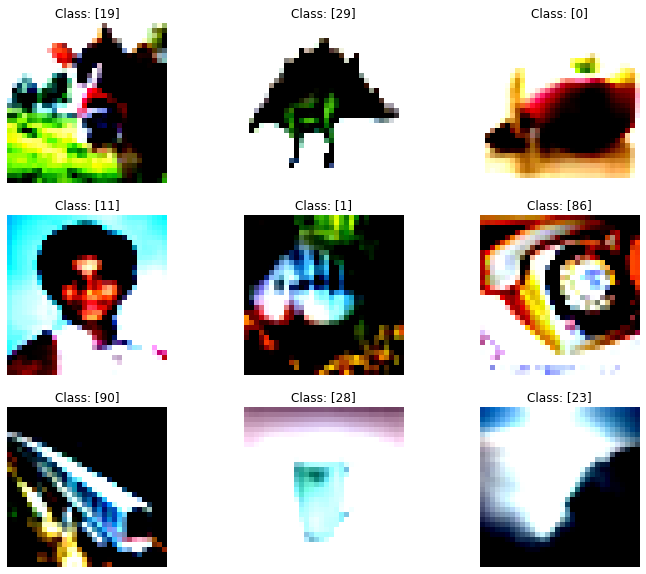

In [4]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in zip(X_train[:9], y_train[:9]):
    index += 1
    plt.subplot(3, 3, index)
    plot_color_image(np.squeeze(image))
    plt.title("Class: {}".format(label))
    plt.axis("off")

plt.show()

<h2> Homemade CNN</h2>
No need batch normalization because the network is not deep so we are not realy concerned by gradient instability. I applied dropout after each convolution layer wich is maybe not very conventional for convolution network (so poetic) but it leads to better accuracy (drop out rates could be fine tuned). 

In [0]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")
model = keras.models.Sequential([
    DefaultConv2D(filters=128, kernel_size=4, input_shape=[32, 32, 3]),
    keras.layers.Dropout(0.1),
    DefaultConv2D(filters=128, strides=2),
    keras.layers.Dropout(0.1),
    DefaultConv2D(filters=256),
    keras.layers.Dropout(0.1),
    DefaultConv2D(filters=256),
    keras.layers.Dropout(0.15),
    DefaultConv2D(filters=256, strides=2),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(units=1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=100, activation='softmax'),
])

In [6]:
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print(model.summary())
history = model.fit(X_train, y_train, epochs=10, validation_data=[X_val, y_val])
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] 
y_pred = model.predict(X_new)
#print the 5 best predictions (best on the right) along the true class num
for pred, true_label in zip(np.argsort(y_pred, axis=1)[:, -5:], y_test[:10]):#axis=0 along col, axis=1->line
  print(pred, true_label, "\t")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       6272      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       5

accuracy : 0.62 val_accuracy : 0.44 (only). 


<h1>Pretrained model</h1>

In [0]:
#X_train = [print(x) for x in X_train]

In [5]:
n_classes =100
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 2s 0us/step


In [0]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)
#base_model.summary()

0 input_5
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_16
13 block2_pool
14 batch_normalization_16
15 add_48
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_17
23 block3_pool
24 batch_normalization_17
25 add_49
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_18
33 block4_pool
34 batch_normalization_18
35 add_50
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_51
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [0]:
from skimage.transform import resize

X_train_resized = np.zeros((45000,224, 224, 3))
X_val_resized = np.zeros((5000,224, 224, 3))
X_test_resized = np.zeros((10000,224, 224, 3))

for i in range(len(X_train)):
  X_train_resized[i] = resize(X_train[i], (224, 224))
for i in range(len(X_val)):
  X_val_resized[i] = resize(X_val[i], (224, 224))
for i in range(len(X_train)):
  X_test_resized[i] = resize(X_test[i], (224, 224))

In [20]:
#freeze every pretrained layer and fit only the last dense layer for output
batch_size=32
for layer in base_model.layers:
    layer.trainable = False
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

history = model.fit(X_train, y_train,
                    steps_per_epoch=int(X_train_resized.shape[0]/batch_size),
                    validation_steps= int(X_val_resized.shape[0]/batch_size),
                    validation_data=[X_val_resized, y_val],
                    epochs=5)

  ...
    to  
  ['...']
Train for 1406.25 steps, validate on 5000 samples
Epoch 1/100
1407/1406 [==============================] - 38s 27ms/step - loss: 4.5537 - accuracy: 0.0349 - val_loss: 4.5802 - val_accuracy: 0.0146
Epoch 2/100
1407/1406 [==============================] - 35s 25ms/step - loss: 4.5360 - accuracy: 0.0397 - val_loss: 4.5778 - val_accuracy: 0.0184
Epoch 3/100
1407/1406 [==============================] - 35s 25ms/step - loss: 4.5294 - accuracy: 0.0406 - val_loss: 4.5753 - val_accuracy: 0.0162
Epoch 4/100
1407/1406 [==============================] - 35s 25ms/step - loss: 4.5253 - accuracy: 0.0396 - val_loss: 4.5769 - val_accuracy: 0.0182
Epoch 5/100
1407/1406 [==============================] - 35s 25ms/step - loss: 4.5234 - accuracy: 0.0438 - val_loss: 4.5749 - val_accuracy: 0.0192
Epoch 6/100
1407/1406 [==============================] - 35s 25ms/step - loss: 4.5192 - accuracy: 0.0432 - val_loss: 4.5728 - val_accuracy: 0.0180
Epoch 7/100
1072/1406 [====================

KeyboardInterrupt: ignored

In [0]:
#then fit the rest with a very smal learning rate so the CNN so we don't break everthing.
#High lr would result in high change in the weights and bias of the Xception base model)
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train,
                    steps_per_epoch=int(X_train_resized.shape[0]/batch_size),
                    validation_steps= int(X_val_resized.shape[0]/batch_size),
                    validation_data=[X_val_resized, y_val],
                    epochs=50)